__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# !pip install plotly ipywidgets plotly-geo

In [2]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import plotly
# import contextily as ctx
# from shapely.geometry import Polygon

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()
# pd.options.plotting.backend = 'plotly'

In [4]:
# !ls -1 data

In [5]:
# import shapely
# shapely.__version__
# '1.8.4'

In [6]:
# !pip install greppo==0.0.32
# !pip install shapely==1.8.2

## считываем данные

In [7]:
data_file = 'data/data_flat.pkl'

In [8]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

39712


,title,adr,latitude,longitude,priceM,ts
38226,"2-комн. кв., 53,7 м², 2/2 этаж","Севастополь, район Нахимовский, улица Будищева, 50",44.599521,33.538592,9.50,2022-11-04 17:14:54.237934
27774,"1-комн. кв., 36 м², 2/9 этаж","Севастополь, район Гагаринский, Камышовая бухта, улица Павла Корчагина, 23",44.585656,33.433651,6.20,2022-09-16 15:11:49.899057
34775,"3-комн. кв., 70 м², 2/5 этаж","Севастополь, район Ленинский, Острякова, улица Николая Музыки, 68",44.582832,33.520644,10.85,2022-10-08 20:39:21.911499


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39712 entries, 0 to 39711
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          39712 non-null  object        
 1   price          39712 non-null  int64         
 2   adr_orig       39712 non-null  object        
 3   description    39712 non-null  object        
 4   obj_name       39712 non-null  object        
 5   ts             39712 non-null  datetime64[ns]
 6   avito_page     21856 non-null  float64       
 7   place          39712 non-null  object        
 8   nrooms         39712 non-null  int64         
 9   floor          39712 non-null  int64         
 10  nfloors        39712 non-null  int64         
 11  area           39712 non-null  float64       
 12  is_studio      39712 non-null  bool          
 13  is_apartment   39712 non-null  bool          
 14  is_part        39712 non-null  bool          
 15  is_auction     3971

In [10]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

39712
39712


### ограничиваем тип объекта 

In [11]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

39712
34088


In [12]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
19482,"1-к. квартира, 26 м², 3/3 эт.","Севастополь,аллея Защитников 35-й Батареи, д. 11а",44.556593,33.412478,4.04
24985,"1-комн. кв., 32,4 м², 9/9 этаж","Севастополь, район Гагаринский, Летчики, проспект Октябрьской Революции, 40/9",44.588346,33.458301,6.50
18191,"2-к. квартира, 61 м², 5/10 эт.","Севастополь, улица Военных Строителей, стр. 6.2",44.567678,33.407492,6.06


In [13]:
df.sample(10)[['title','adr','url']].to_dict('records') 

[{'title': '1-комн. апарт., 19 м², 6/10 этаж',
  'adr': 'Севастополь, район Гагаринский, улица Адмирала Фадеева, 48',
  'url': 'https://sevastopol.cian.ru/sale/flat/275690398/'},
 {'title': '1-к. квартира, 66,8\xa0м², 5/9\xa0эт.',
  'adr': 'Севастополь, улица Токарева, 7 этап, блок-секция 3',
  'url': 'https://avito.ru/2505715556'},
 {'title': '1-к. квартира, 30,5\xa0м², 2/9\xa0эт.',
  'adr': 'Севастополь, проспект Генерала Острякова, 152',
  'url': 'https://avito.ru/2431112949'},
 {'title': '1-комн. кв., 25 м², 5/5 этаж',
  'adr': 'Севастополь, район Ленинский, Острякова, проспект Генерала Острякова, 172',
  'url': 'https://sevastopol.cian.ru/sale/flat/278099301/'},
 {'title': '2-к. квартира, 77,9\xa0м², 1/9\xa0эт.',
  'adr': 'Севастополь, улица Горпищенко, д. 139',
  'url': 'https://avito.ru/2537301754'},
 {'title': '1-комн. кв., 30,6 м², 3/5 этаж',
  'adr': 'Севастополь, район Гагаринский, Летчики, проспект Октябрьской Революции, 57',
  'url': 'https://sevastopol.cian.ru/sale/flat/2

In [14]:
# gdf.sample(3)[['title','adr','latitude','longitude','priceM']].to_json()

In [15]:
# gdf.to_file(data_file.replace('.pkl','.shp'))

In [16]:
# gdf.to_file(data_file.replace('.pkl','.geojson'), driver='GeoJSON')

In [17]:
# gdf.to_file(data_file.replace('.pkl','.gpkg'), layer='points', driver="GPKG")

In [18]:
del df

In [19]:
gdf[['title','adr','priceM','geometry']].sample(100).explore()

## общая статистика изменение цены

In [20]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['nrooms','dt'])
    ['priceM']
    .describe(percentiles=[.01,.1,.25,.5,.75,.9])
)

stat

count  mean  std  min   1%   10%   25%   50%   75%   90%  \
nrooms dt                                                                      
1      2022-08-26 1203.00  6.26 1.91 1.59 2.31  4.07  5.00  6.00  7.30  8.50   
       2022-08-29 1191.00  6.25 1.90 1.75 2.73  4.11  5.00  6.00  7.21  8.50   
       2022-08-31 1180.00  6.34 1.92 1.30 2.72  4.20  5.09  6.00  7.43  8.76   
       2022-09-01 1159.00  6.32 1.89 1.30 2.78  4.15  5.10  6.00  7.40  8.51   
       2022-09-02  365.00  6.31 2.10 3.65 3.65  4.00  4.85  5.81  7.21  9.35   
       2022-09-05  372.00  6.21 2.10 3.10 3.61  3.99  4.81  5.55  7.07  9.35   
       2022-09-06  372.00  6.22 2.10 3.15 3.64  3.99  4.83  5.62  7.05  9.33   
       2022-09-07  320.00  6.35 2.10 3.10 3.62  4.09  4.87  5.80  7.26  9.35   
       2022-09-08 1031.00  5.92 2.35 1.40 1.82  3.50  4.25  5.42  7.10  9.00   
       2022-09-12  906.00  5.89 2.35 1.40 1.80  3.49  4.40  5.42  7.00  8.70   
       2022-09-13  910.00  5.96 2.41 1.40 1.80  3.40  4.30  5.50  7.20  9.12   
       2022-09-15  916.00  5.91 2.30 1.40 1.72  3.49  4.45  5.50  7.00  8.86   
       2022-09-16  830.00  6.43 2.66 1.40 2.27  3.98  5.00  5.95  7.29  9.41   
       2022-09-19  810.00  6.42 2.68 1.40 2.23  3.94  5.00  5.90  7.30  9.35   
       2022-09-22  797.00  6.43 2.57 1.40 2.44  4.20  5.10  5.95  7.30  9.06   
       2022-09-26  845.00  6.33 1.96 1.47 2.64  4.30  5.00  5.95  7.20  8.78   
       2022-10-08  869.00  6.09 1.89 1.40 2.50  4.00  4.92  5.80  7.00  8.50   
       2022-10-14  888.00  6.04 1.89 1.40 2.19  4.20  4.85  5.70  7.00  8.56   
       2022-11-01  732.00  6.27 2.37 1.47 2.54  4.45  5.00  5.90  7.00  8.50   
       2022-11-04  769.00  6.10 2.43 1.40 1.83  3.91  4.95  5.75  6.95  8.50   
2      2022-08-26  941.00  8.82 3.30 2.80 3.97  5.80  6.60  8.15 10.21 12.67   
       2022-08-29  936.00  8.87 3.30 2.80 4.09  5.88  6.70  8.19 10.42 12.64   
       2022-08-31  925.00  8.83 3.20 2.60 4.06  5.80  6.69  8.10 10.35 12.85   
       2022-09-01  947.00  8.91 3.32 2.65 4.12  5.80  6.70  8.18 10.50 12.90   
       2022-09-02  112.00  9.66 2.65 4.91 5.06  6.36  7.55  9.43 11.53 12.97   
       2022-09-05  131.00  9.76 2.70 4.92 5.65  6.40  8.00  9.28 11.37 13.65   
       2022-09-06  187.00  9.71 2.69 4.91 4.95  6.32  7.83  9.28 11.45 13.65   
       2022-09-07  128.00  9.75 2.85 4.91 5.94  6.20  7.49  9.14 11.77 13.93   
       2022-09-08  560.00  9.44 4.16 3.20 3.97  6.00  6.74  8.39 11.13 13.65   
       2022-09-12  476.00  9.25 4.34 3.00 3.98  5.70  6.60  8.22 10.88 13.63   
       2022-09-13  474.00  9.16 4.38 3.00 3.77  5.65  6.54  8.18 10.61 13.60   
       2022-09-15  495.00  9.10 4.16 3.00 4.19  5.90  6.60  8.18 10.60 13.58   
       2022-09-16  576.00  9.45 4.12 1.70 4.62  6.07  6.98  8.32 10.80 13.63   
       2022-09-19  569.00  9.30 4.11 3.20 4.62  5.90  6.90  8.25 10.79 13.50   
       2022-09-22  566.00  9.32 4.13 3.20 4.62  5.90  6.80  8.25 10.80 13.50   
       2022-09-26  593.00  8.60 3.55 3.80 4.53  5.89  6.55  8.00  9.52 12.08   
       2022-10-08  596.00  8.59 3.62 3.55 4.50  5.80  6.70  8.02  9.41 11.92   
       2022-10-14  569.00  8.50 3.54 3.80 4.50  5.80  6.70  7.97  9.30 11.92   
       2022-11-01  547.00  8.90 3.62 2.90 4.18  5.70  6.70  8.03 10.01 13.00   
       2022-11-04  563.00  8.93 3.56 3.65 4.80  5.80  6.70  8.18 10.00 12.98   
3      2022-08-26  646.00 11.61 6.14 3.50 5.22  7.40  8.30 10.25 13.24 16.80   
       2022-08-29  635.00 11.66 6.17 3.85 6.00  7.40  8.43 10.33 13.28 16.68   
       2022-08-31  640.00 11.64 6.12 3.85 5.99  7.40  8.44 10.30 13.03 17.03   
       2022-09-01  634.00 11.57 6.13 3.85 5.99  7.40  8.30 10.21 13.00 16.90   
       2022-09-02   61.00 11.17 1.74 7.73 8.61 10.21 10.33 10.35 11.53 13.90   
       2022-09-05   67.00 11.22 1.85 7.73 8.70 10.21 10.33 10.35 12.03 14.18   
       2022-09-06   65.00 11.22 1.87 7.73 8.67 10.21 10.33 10.34 11.53 14.27   
       2022-09-07   58.00 11.26 1.81 9.20 9.48 10.21 10.33 10.35 11.35 14.13   
       2022-09-08  2

In [21]:
( # количество предложений
    gdf.query('priceM>1.')
    .groupby(['nrooms'])
    [['title']].count()
).T

nrooms,1,2,3
title,16465,10891,6732


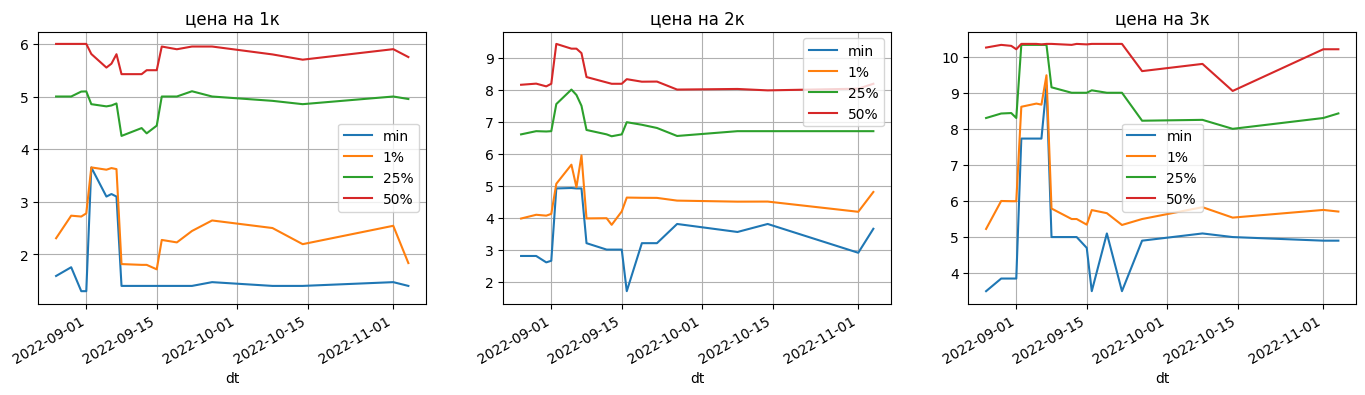

In [22]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]

#fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=True )
fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,['min','1%','25%','50%']].plot(title=f'цена на {k}к', grid=True,ax=ax[i] )    

### район поиска

In [23]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [24]:
frame_all.explore()

In [25]:
frame_all.to_file('data/frame_all.geojson', driver='GeoJSON')

### гексагональная сетка

In [26]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [27]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0],cell_size=6 )
print(len(grid))
grid.sample(2)

24


,hex_id,geometry
21,862d28857ffffff,"POLYGON ((33.71787 44.53737, 33.69643 44.50794, 33.72323 44.47910, 33.77146 44.47968, 33.79291 44.50910, 33.76613 44.53794, 33.71787 44.53737))"
3,862d2880fffffff,"POLYGON ((33.64817 44.50734, 33.62675 44.47788, 33.65358 44.44905, 33.70180 44.44966, 33.72323 44.47910, 33.69643 44.50794, 33.64817 44.50734))"


In [28]:
# grid.explore()

### медиана актуальной цены

In [29]:
ts = '2022-08-01' # ограничиваем дату

# новые предложения
gdf_ = gdf[ (gdf['dt']>ts)  ] # & (gdf['priceM']<15.)

grid_values = ( 
    grid
    .sjoin(gdf_, how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [30]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [31]:
frames.explore('area_name', legend=True)

In [32]:
frames.to_file('data/frames.geojson', driver='GeoJSON')

In [33]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
# 'Севастополь, Малахов курган',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

34088
2908


In [34]:
frames.iloc[[0]]

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"


In [35]:
# новые (актуальные) предложения
# gdf_[gdf_['ts']>ts][['title','priceM','adr','geometry']].explore( legend=False)
gdf_[['title','priceM','adr','geometry']].explore( legend=False)

### изменение цены

In [36]:
( # количество предложений
    gdf_.query('priceM>1.')
    .groupby(['nrooms'])
    [['title']].count()
).T

nrooms,1,2,3
title,957,1144,807


In [37]:
stat = gdf_.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
stat

count  mean  std   min    1%   10%   25%   50%   75%   90%  \
nrooms dt                                                                       
1      2022-08-26  87.00  5.70 1.56  1.85  1.98  4.10  4.77  5.50  6.75  7.57   
       2022-08-29  95.00  5.70 1.58  1.85  1.99  4.10  4.82  5.60  6.68  7.58   
       2022-08-31  97.00  5.64 1.45  1.85  1.98  4.10  4.90  5.60  6.50  7.50   
       2022-09-01  95.00  5.65 1.43  1.85  1.98  4.10  4.90  5.60  6.68  7.53   
       2022-09-08  54.00  5.03 1.52  1.85  2.03  3.06  4.12  4.93  5.90  6.98   
       2022-09-12  53.00  4.94 1.42  1.85  2.03  3.04  4.25  4.90  5.70  6.61   
       2022-09-13  42.00  4.82 1.52  1.85  1.99  2.87  4.12  4.55  5.65  6.65   
       2022-09-15  53.00  4.97 1.44  1.85  2.03  3.04  4.25  4.85  5.60  6.78   
       2022-09-16  38.00  5.54 1.34  1.85  2.61  4.17  4.81  5.35  6.44  7.10   
       2022-09-19  35.00  5.65 1.31  1.85  2.55  4.60  4.90  5.40  6.38  7.02   
       2022-09-22  46.00  5.70 1.32  1.85  2.37  4.70  5.10  5.45  6.35  7.42   
       2022-09-26  49.00  5.74 1.34  1.60  2.70  4.56  4.90  5.50  6.50  7.18   
       2022-10-08  67.00  5.47 1.32  1.85  2.77  4.70  4.76  4.90  6.05  6.92   
       2022-10-14  66.00  5.84 1.51  1.85  2.76  4.50  4.75  5.35  6.70  8.00   
       2022-11-01  42.00  5.80 1.26  3.99  4.14  4.60  4.90  5.45  6.20  7.95   
       2022-11-04  38.00  5.78 1.48  1.85  2.37  4.56  5.15  5.50  6.42  8.05   
2      2022-08-26 125.00  7.97 2.12  5.40  5.42  6.24  6.50  7.30  8.50 10.82   
       2022-08-29 125.00  8.05 2.14  4.90  5.32  6.04  6.50  7.49  9.00 10.99   
       2022-08-31 127.00  7.89 2.08  4.90  5.19  5.98  6.50  7.20  8.65 10.78   
       2022-09-01 132.00  7.83 2.05  4.90  5.23  5.81  6.50  7.20  8.50 10.52   
       2022-09-08  48.00  7.93 2.35  4.90  5.18  6.09  6.40  6.95  8.75 11.12   
       2022-09-12  47.00  7.76 2.41  4.90  5.02  5.83  6.30  6.90  8.60 11.16   
       2022-09-13  46.00  7.84 2.40  5.15  5.31  5.92  6.30  6.90  8.65 11.20   
       2022-09-15  49.00  7.75 2.36  4.90  5.02  5.78  6.30  6.90  8.50 11.08   
       2022-09-16  47.00  7.85 2.17  4.90  5.13  6.00  6.30  7.05  8.50 11.29   
       2022-09-19  45.00  7.56 2.12  4.90  5.01  5.62  6.30  6.99  8.10 11.11   
       2022-09-22  57.00  7.98 2.98  3.80  4.58  5.68  6.20  7.00  8.49 12.50   
       2022-09-26  58.00  7.13 1.48  3.80  4.66  5.79  6.20  6.85  7.70  8.89   
       2022-10-08  60.00  7.03 1.54  3.55  4.23  5.36  6.20  6.90  7.50  8.67   
       2022-10-14  66.00  7.35 1.50  4.70  4.90  5.80  6.45  7.12  7.94  8.65   
       2022-11-01  54.00  7.73 2.11  4.60  4.60  5.73  6.33  7.12  8.50 11.40   
       2022-11-04  58.00  7.58 2.19  3.65  4.31  5.50  6.30  7.00  8.42 11.08   
3      2022-08-26  90.00  9.68 2.39  6.90  6.90  7.30  7.83  9.00 10.78 13.50   
       2022-08-29  85.00  9.64 2.29  6.90  6.90  7.24  7.80  9.00 10.80 13.30   
       2022-08-31  86.00  9.67 2.29  6.90  6.90  7.40  7.84  9.15 11.00 13.25   
       2022-09-01  85.00  9.56 2.30  6.90  6.98  7.38  7.80  9.00 10.70 13.18   
       2022-09-02   2.00 12.50 1.41 11.50 11.52 11.70 12.00 12.50 13.00 13.30   
       2022-09-05   3.00 11.70 1.56 10.80 10.80 10.80 10.80 10.80 12.15 12.96   
       2022-09-06   2.00 12.15 1.91 10.80 10.83 11.07 11.48 12.15 12.82 13.23   
       2022-09-07   2.00 12.15 1.91 10.80 10.83 11.07 11.48 12.15 12.82 13.23   
       2022-09-08  27.00 10.05 2.01  7.30  7.40  8.10  8.75  9.45 10.50 12.60   
       2022-09-12  33.00  9.53 2.11  6.90  6.90  7.30  7.95  9.10 10.50 11.90   
       2022-09-13  35.00  9.87 2.34  6.90  6.90  7.38  8.35  9.45 10.50 12.90   
       2022-09-15  32.00 10.00 2.40  6.90  6.90  7.32  8.38  9.70 10.55 13.35   
       2022-09-16  38.00 10.36 2.61  6.90  6.93  7.44  8.33 10.05 11.50 13.95   
       2022-09-19  33.00 10.47 2.73  6.90  6.93  7.40  8.30 10.10 12.00 14.70   
       2022-09-22  39.00 10.00 2.70  4.90  5.66  7.28  8.30  9.00 11.40 13.80   
       2022-09-26  38.00  9.08 2.15  6.50  6.65  7

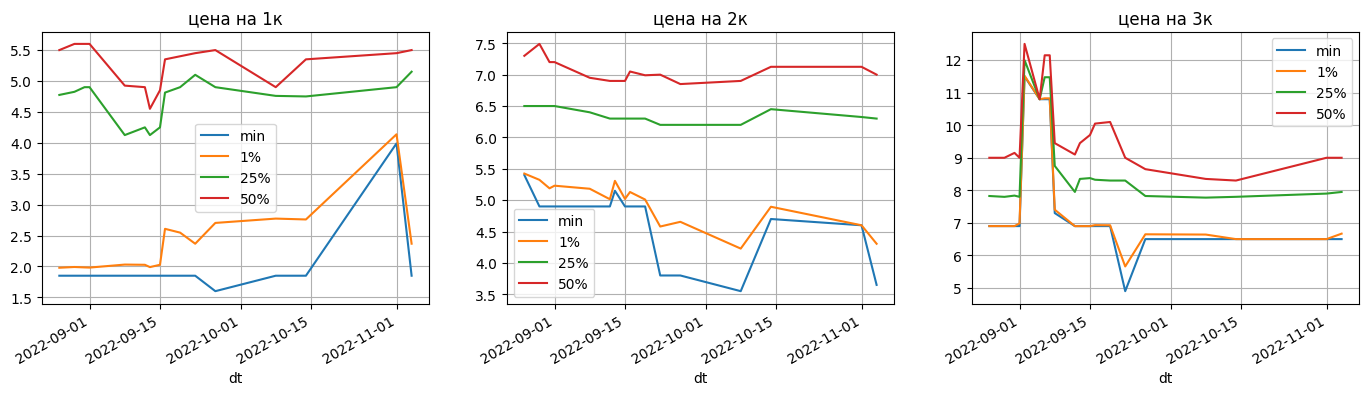

In [38]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]

# fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=True )
fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,['min','1%','25%','50%']].plot(title=f'цена на {k}к', grid=True,ax=ax[i] )    

### гексагональная сетка

In [39]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
37,892d2894253ffff,"POLYGON ((33.52576 44.56583, 33.52543 44.56404, 33.52752 44.56288, 33.52993 44.56351, 33.53025 44.56530, 33.52817 44.56646, 33.52576 44.56583))"
9,892d28942d7ffff,"POLYGON ((33.51774 44.57227, 33.51742 44.57048, 33.51951 44.56932, 33.52191 44.56995, 33.52224 44.57174, 33.52015 44.57290, 33.51774 44.57227))"


### медиана актуальной цены

In [40]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)